In [1]:
%matplotlib widget

import os
os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".2"

import abtem
import ase
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpy as np

from wide_angle_propagation import (
    get_abtem_transmit,
    energy2wavelength,
    simulate_fresnel_as,
    simulate_wpm,
    fresnel_propagation_kernel,
    angular_spectrum_propagation_kernel
)


abtem.config.set({"device": "cpu"})
abtem.config.set({"precision": "float64"})
jax.config.update("jax_enable_x64", True)

In [2]:
# Create a single Au atom in a small cell
atoms = ase.Atoms('Au', cell=[5, 5, 5], pbc=True)
atoms.center()

In [3]:
energy = 80e3
wavelength = energy2wavelength(energy)  # 80 keV electrons
k = 2 * jnp.pi / wavelength

In [4]:
base_slice_thickness = 0.05

potential = abtem.Potential(
    atoms,
    gpts=128,
    slice_thickness=base_slice_thickness,
    projection='finite',
)
print('potential.shape =', potential.shape)

potential.sampling

potential.shape = (100, 128, 128)


(0.0390625, 0.0390625)

(<Figure size 1000x400 with 2 Axes>,
 <Axes: title={'center': 'Top view'}, xlabel='x [Å]', ylabel='z [Å]'>)

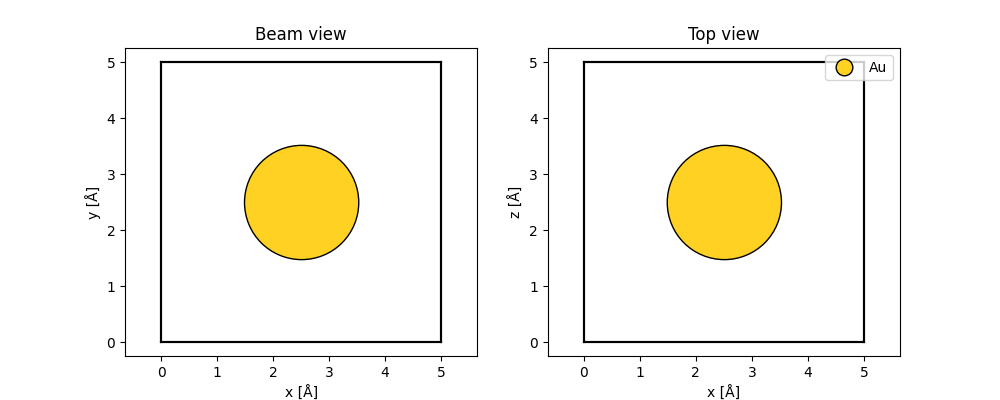

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Top view", legend=True)

In [6]:
transmit = get_abtem_transmit(potential, energy)


In [7]:
potential_array = potential.build(lazy=False).array

In [8]:
wavelength = energy2wavelength(energy)
semiangle_cutoff = 50
defocus = 2.5
astigmatism = 0.,
astigmatism_angle = 0.,

# probe = abtem.PlaneWave(energy=energy)
# probe.grid.match(potential)
probe = abtem.Probe(
    energy=energy,
    semiangle_cutoff=semiangle_cutoff,
    defocus=defocus,
)
probe.grid.match(potential)
probe_array = probe.build(lazy=False).array

Text(0.5, 1.0, 'Probe abtem (angle)')

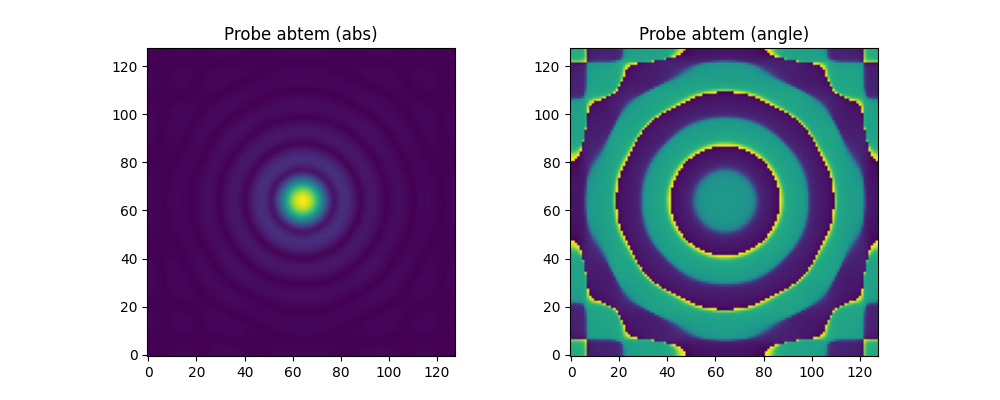

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
ax1.imshow(np.abs(probe.build(lazy=False).array), origin='lower')
ax1.set_title('Probe abtem (abs)')
ax2.imshow(np.angle(probe.build(lazy=False).array), origin='lower')
ax2.set_title('Probe abtem (angle)')

In [10]:
# Extract sampling as separate values to ensure proper type handling
sampling_x, sampling_y = probe.grid.sampling[0], probe.grid.sampling[1]

fresnel_propagator = fresnel_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    (sampling_x, sampling_y),
    z=base_slice_thickness,
    energy=probe.energy,
)

angular_spectrum_propagator = angular_spectrum_propagation_kernel(
    probe.grid.gpts[0],
    probe.grid.gpts[1],
    (sampling_x, sampling_y),
    z=base_slice_thickness,
    energy=probe.energy,
)

potential_array = potential_array / base_slice_thickness

exit_wave_as, diffraction_pattern_as, wavefronts_as = simulate_fresnel_as(
    potential_array, probe_array, angular_spectrum_propagator, base_slice_thickness, energy
)
exit_wave_fresnel, diffraction_pattern_fresnel, wavefronts_fresnel = simulate_fresnel_as(
    potential_array, probe_array, fresnel_propagator, base_slice_thickness, energy
)

In [11]:
exit_wave_wpm, diffraction_pattern_wpm, wavefronts_wpm = simulate_wpm(
    potential_array, probe_array, base_slice_thickness, energy, (sampling_x, sampling_y),
    256, 2.0  # n_bins, power_spacing passed as positional args
)

## Quick Visual Check: First Wavefronts
Plot the first wavefront from each method (intensity).

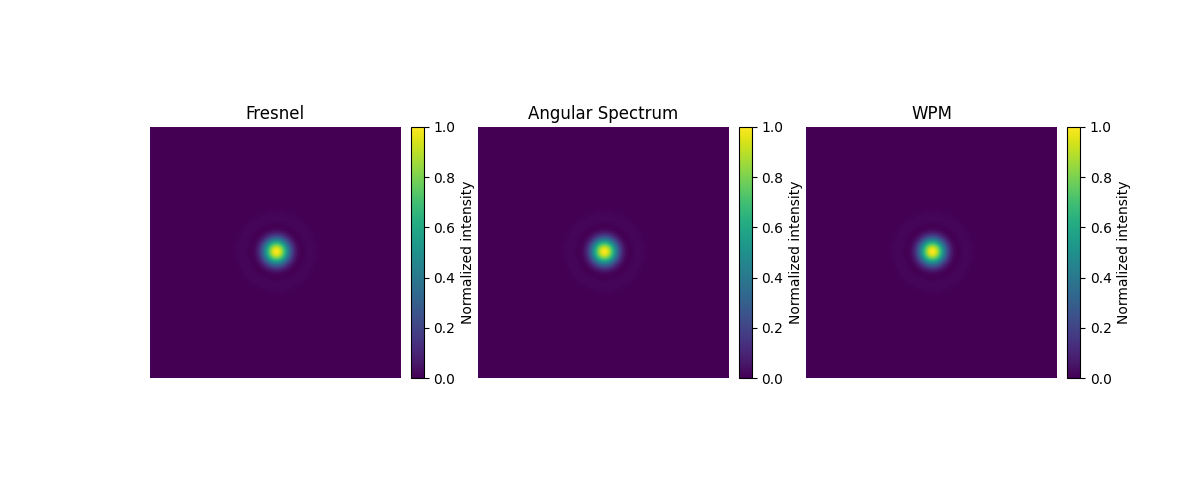

In [13]:
# plot first wavefront (index 0) for each method: Fresnel, Angular Spectrum, WPM
fig, axs = plt.subplots(1, 3, figsize=(12, 5))

wf_f = np.asarray(wavefronts_fresnel[0])
wf_a = np.asarray(wavefronts_as[0])
wf_w = np.asarray(wavefronts_wpm[0])

# plot intensity (|ψ|^2) with a shared color scale normalized to [0,1]
int_f = np.abs(wf_f) ** 2
int_a = np.abs(wf_a) ** 2
int_w = np.abs(wf_w) ** 2
# global max across the three methods to normalize for fair comparison
global_max = max(int_f.max(), int_a.max(), int_w.max()) if max(int_f.max(), int_a.max(), int_w.max()) > 0 else 1.0
int_f = (int_f / global_max).astype(np.float32)
int_a = (int_a / global_max).astype(np.float32)
int_w = (int_w / global_max).astype(np.float32)

imgs = [int_f, int_a, int_w]
titles = ["Fresnel", "Angular Spectrum", "WPM"]

for ax, img, title in zip(axs, imgs, titles):
    im = ax.imshow(img, origin='lower', cmap='viridis', vmin=0.0, vmax=1.0)
    ax.set_title(title)
    ax.axis('off')
    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04, label="Normalized intensity")

## Slice-by-slice Comparison: Intensity and Phase (Normalized)
The plots below show cross-sections (center row) of the wavefronts for each slice. Intensities are normalized to the same global maximum so differences are directly comparable. Phases are wrapped to [-π, π].

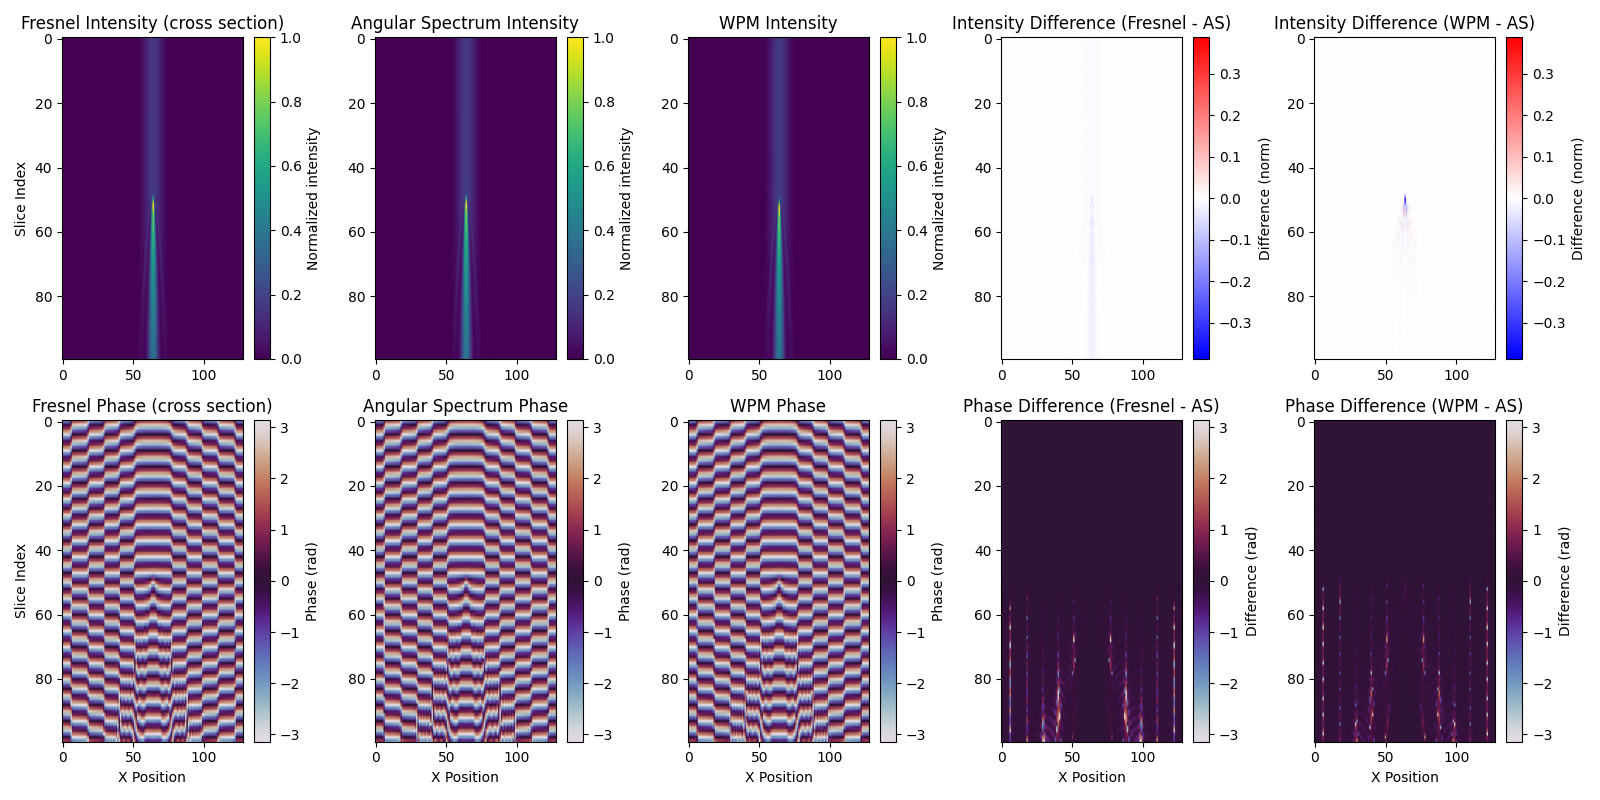

In [14]:
fig, ax = plt.subplots(2, 5, figsize=(16, 8))

# Calculate intensities (cross-section at center y). Convert to numpy arrays first
intensity_fresnel = np.abs(np.asarray(wavefronts_fresnel[:, wavefronts_fresnel.shape[1]//2, :]))**2
intensity_as = np.abs(np.asarray(wavefronts_as[:, wavefronts_as.shape[1]//2, :]))**2
intensity_wpm = np.abs(np.asarray(wavefronts_wpm[:, wavefronts_wpm.shape[1]//2, :]))**2

# Normalize each relative to their own maximum
intensity_fresnel = (intensity_fresnel / intensity_fresnel.max()).astype(np.float32)
intensity_as = (intensity_as / intensity_as.max()).astype(np.float32)
intensity_wpm = (intensity_wpm / intensity_wpm.max()).astype(np.float32)

# Intensity differences
intensity_diff_f_as = intensity_fresnel - intensity_as
intensity_diff_w_as = intensity_wpm - intensity_as

# Calculate phases
phase_fresnel = np.angle(np.asarray(wavefronts_fresnel[:, wavefronts_fresnel.shape[1]//2, :]))
phase_as = np.angle(np.asarray(wavefronts_as[:, wavefronts_as.shape[1]//2, :]))
phase_wpm = np.angle(np.asarray(wavefronts_wpm[:, wavefronts_wpm.shape[1]//2, :]))

# Phase differences and wrap to [-pi, pi]
phase_diff_f_as = (phase_fresnel - phase_as + np.pi) % (2 * np.pi) - np.pi
phase_diff_w_as = (phase_wpm - phase_as + np.pi) % (2 * np.pi) - np.pi

# --- Row 1: Intensity ---
# Fresnel
im_fresnel = ax[0, 0].imshow(intensity_fresnel, aspect='auto', origin='upper', vmin=0.0, vmax=1.0, cmap='viridis')
ax[0, 0].set_title("Fresnel Intensity (cross section)")
ax[0, 0].set_ylabel("Slice Index")
fig.colorbar(im_fresnel, ax=ax[0, 0], label="Normalized intensity")

# Angular Spectrum
im_as = ax[0, 1].imshow(intensity_as, aspect='auto', origin='upper', vmin=0.0, vmax=1.0, cmap='viridis')
ax[0, 1].set_title("Angular Spectrum Intensity")
fig.colorbar(im_as, ax=ax[0, 1], label="Normalized intensity")

# WPM
im_wpm = ax[0, 2].imshow(intensity_wpm, aspect='auto', origin='upper', vmin=0.0, vmax=1.0, cmap='viridis')
ax[0, 2].set_title("WPM Intensity")
fig.colorbar(im_wpm, ax=ax[0, 2], label="Normalized intensity")

# Intensity Difference (Fresnel - AS)
vmax_diff = np.max(np.abs(np.stack([intensity_diff_f_as, intensity_diff_w_as]))) if np.max(np.abs(np.stack([intensity_diff_f_as, intensity_diff_w_as])))>0 else 1.0
im_diff_f_as = ax[0, 3].imshow(intensity_diff_f_as, aspect='auto', origin='upper', cmap='bwr', vmin=-vmax_diff, vmax=vmax_diff)
ax[0, 3].set_title("Intensity Difference (Fresnel - AS)")
fig.colorbar(im_diff_f_as, ax=ax[0, 3], label="Difference (norm)")

# Intensity Difference (WPM - AS)
im_diff_w_as = ax[0, 4].imshow(intensity_diff_w_as, aspect='auto', origin='upper', cmap='bwr', vmin=-vmax_diff, vmax=vmax_diff)
ax[0, 4].set_title("Intensity Difference (WPM - AS)")
fig.colorbar(im_diff_w_as, ax=ax[0, 4], label="Difference (norm)")

# --- Row 2: Phase ---
# Fresnel Phase
p_fresnel = ax[1, 0].imshow(phase_fresnel, aspect='auto', origin='upper', cmap='twilight', vmin=-np.pi, vmax=np.pi)
ax[1, 0].set_title("Fresnel Phase (cross section)")
ax[1, 0].set_xlabel("X Position")
ax[1, 0].set_ylabel("Slice Index")
fig.colorbar(p_fresnel, ax=ax[1, 0], label="Phase (rad)")

# Angular Spectrum Phase
p_as = ax[1, 1].imshow(phase_as, aspect='auto', origin='upper', cmap='twilight', vmin=-np.pi, vmax=np.pi)
ax[1, 1].set_title("Angular Spectrum Phase")
ax[1, 1].set_xlabel("X Position")
fig.colorbar(p_as, ax=ax[1, 1], label="Phase (rad)")

# WPM Phase
p_wpm = ax[1, 2].imshow(phase_wpm, aspect='auto', origin='upper', cmap='twilight', vmin=-np.pi, vmax=np.pi)
ax[1, 2].set_title("WPM Phase")
ax[1, 2].set_xlabel("X Position")
fig.colorbar(p_wpm, ax=ax[1, 2], label="Phase (rad)")

# Phase Difference (Fresnel - AS)
im_diff_phase_f_as = ax[1, 3].imshow(phase_diff_f_as, aspect='auto', origin='upper', cmap='twilight', vmin=-np.pi, vmax=np.pi)
ax[1, 3].set_title("Phase Difference (Fresnel - AS)")
ax[1, 3].set_xlabel("X Position")
fig.colorbar(im_diff_phase_f_as, ax=ax[1, 3], label="Difference (rad)")

# Phase Difference (WPM - AS)
im_diff_phase_w_as = ax[1, 4].imshow(phase_diff_w_as, aspect='auto', origin='upper', cmap='twilight', vmin=-np.pi, vmax=np.pi)
ax[1, 4].set_title("Phase Difference (WPM - AS)")
ax[1, 4].set_xlabel("X Position")
fig.colorbar(im_diff_phase_w_as, ax=ax[1, 4], label="Difference (rad)")

plt.tight_layout()

## Exit Wave & Diffraction Pattern Comparison (Normalized)
Exit waves and diffraction patterns are normalized per-image to the range [0,1] for display. Differences use a symmetric diverging colormap.

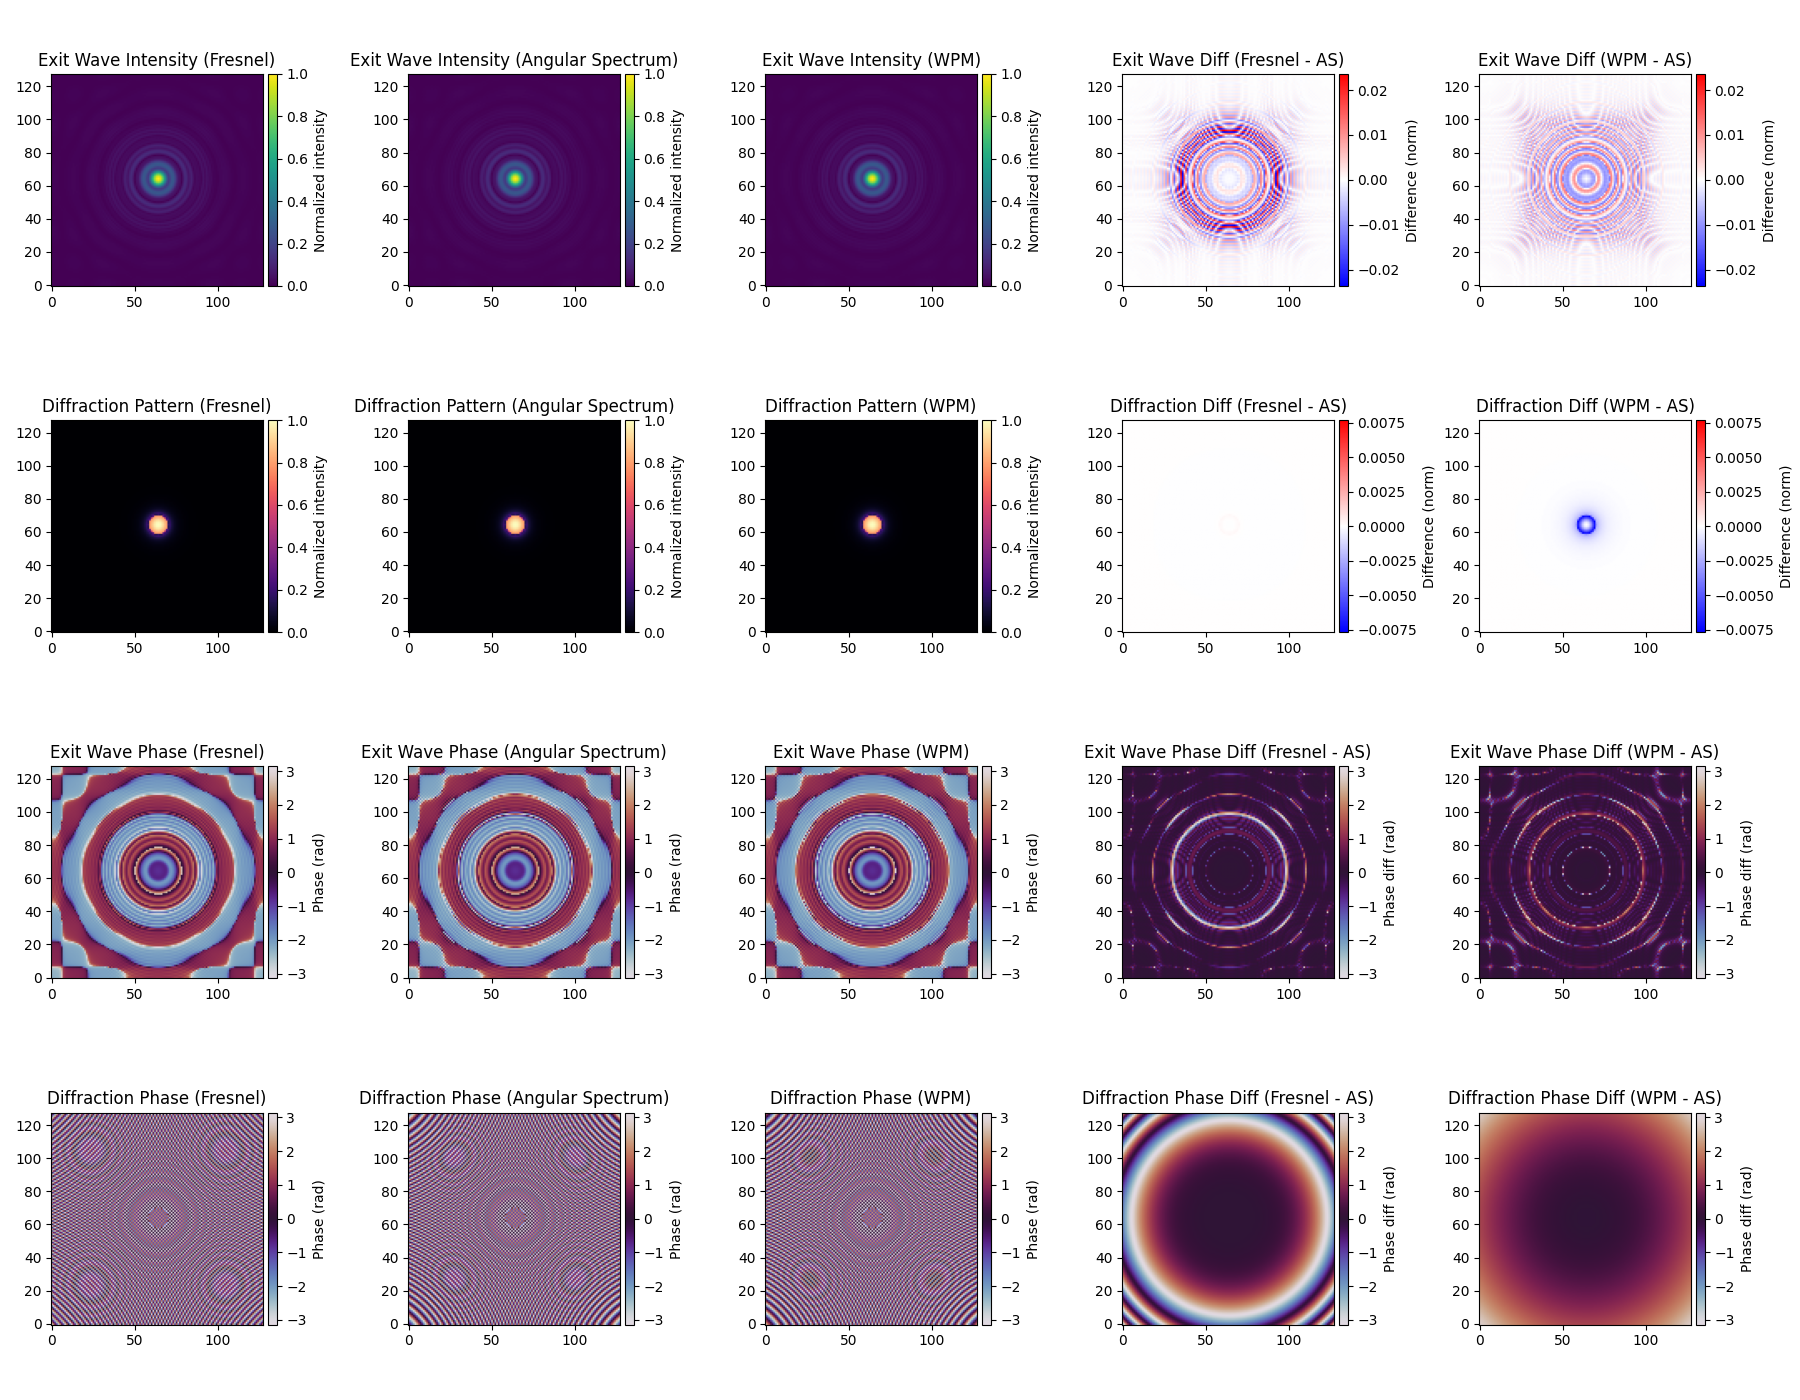

In [15]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# expand to include two extra rows: exit wave phase and diffraction phase
fig, axs = plt.subplots(4, 5, figsize=(18, 14))

# helper to create cax with same height as axis
def add_colorbar(ax, im, size="4%", pad=0.05, **kwargs):
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size=size, pad=pad)
    return fig.colorbar(im, cax=cax, **kwargs)

# --- Row 0: Exit Wave Intensity ---
ew_f = np.abs(np.asarray(exit_wave_fresnel))
ew_a = np.abs(np.asarray(exit_wave_as))
ew_w = np.abs(np.asarray(exit_wave_wpm))

def norm01(x):
    m = x.max() if x.max() != 0 else 1.0
    return (x / m).astype(np.float32)

ew_f_n = norm01(ew_f)
ew_a_n = norm01(ew_a)
ew_w_n = norm01(ew_w)

im = axs[0, 0].imshow(ew_f_n, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis')
axs[0, 0].set_title("Exit Wave Intensity (Fresnel)")
add_colorbar(axs[0, 0], im, label="Normalized intensity")

im = axs[0, 1].imshow(ew_a_n, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis')
axs[0, 1].set_title("Exit Wave Intensity (Angular Spectrum)")
add_colorbar(axs[0, 1], im, label="Normalized intensity")

im = axs[0, 2].imshow(ew_w_n, origin='lower', vmin=0.0, vmax=1.0, cmap='viridis')
axs[0, 2].set_title("Exit Wave Intensity (WPM)")
add_colorbar(axs[0, 2], im, label="Normalized intensity")

diff_ew_f_as = ew_f_n - ew_a_n
diff_ew_w_as = ew_w_n - ew_a_n
vmax_ew = np.max(np.abs(np.stack([diff_ew_f_as, diff_ew_w_as]))) if np.max(np.abs(np.stack([diff_ew_f_as, diff_ew_w_as]))) > 0 else 1.0

im = axs[0, 3].imshow(diff_ew_f_as, cmap='bwr', origin='lower', vmin=-vmax_ew, vmax=vmax_ew)
axs[0, 3].set_title("Exit Wave Diff (Fresnel - AS)")
add_colorbar(axs[0, 3], im, label="Difference (norm)")

im = axs[0, 4].imshow(diff_ew_w_as, cmap='bwr', origin='lower', vmin=-vmax_ew, vmax=vmax_ew)
axs[0, 4].set_title("Exit Wave Diff (WPM - AS)")
add_colorbar(axs[0, 4], im, label="Difference (norm)")


# --- Row 1: Diffraction Pattern Intensity ---
dp_f = np.asarray(diffraction_pattern_fresnel)
dp_a = np.asarray(diffraction_pattern_as)
dp_w = np.asarray(diffraction_pattern_wpm)

dp_f_n = norm01(dp_f)
dp_a_n = norm01(dp_a)
dp_w_n = norm01(dp_w)

im = axs[1, 0].imshow(dp_f_n, origin='lower', vmin=0.0, vmax=1.0, cmap='magma')
axs[1, 0].set_title("Diffraction Pattern (Fresnel)")
add_colorbar(axs[1, 0], im, label="Normalized intensity")

im = axs[1, 1].imshow(dp_a_n, origin='lower', vmin=0.0, vmax=1.0, cmap='magma')
axs[1, 1].set_title("Diffraction Pattern (Angular Spectrum)")
add_colorbar(axs[1, 1], im, label="Normalized intensity")

im = axs[1, 2].imshow(dp_w_n, origin='lower', vmin=0.0, vmax=1.0, cmap='magma')
axs[1, 2].set_title("Diffraction Pattern (WPM)")
add_colorbar(axs[1, 2], im, label="Normalized intensity")

diff_dp_f_as = dp_f_n - dp_a_n
diff_dp_w_as = dp_w_n - dp_a_n
vmax_dp = np.max(np.abs(np.stack([diff_dp_f_as, diff_dp_w_as]))) if np.max(np.abs(np.stack([diff_dp_f_as, diff_dp_w_as]))) > 0 else 1.0

im = axs[1, 3].imshow(diff_dp_f_as, cmap='bwr', origin='lower', vmin=-vmax_dp, vmax=vmax_dp)
axs[1, 3].set_title("Diffraction Diff (Fresnel - AS)")
add_colorbar(axs[1, 3], im, label="Difference (norm)")

im = axs[1, 4].imshow(diff_dp_w_as, cmap='bwr', origin='lower', vmin=-vmax_dp, vmax=vmax_dp)
axs[1, 4].set_title("Diffraction Diff (WPM - AS)")
add_colorbar(axs[1, 4], im, label="Difference (norm)")


# --- Row 2: Exit Wave Phase ---
ph_ew_f = np.angle(np.asarray(exit_wave_fresnel))
ph_ew_a = np.angle(np.asarray(exit_wave_as))
ph_ew_w = np.angle(np.asarray(exit_wave_wpm))

im = axs[2, 0].imshow(ph_ew_f, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[2, 0].set_title("Exit Wave Phase (Fresnel)")
add_colorbar(axs[2, 0], im, label="Phase (rad)")

im = axs[2, 1].imshow(ph_ew_a, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[2, 1].set_title("Exit Wave Phase (Angular Spectrum)")
add_colorbar(axs[2, 1], im, label="Phase (rad)")

im = axs[2, 2].imshow(ph_ew_w, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[2, 2].set_title("Exit Wave Phase (WPM)")
add_colorbar(axs[2, 2], im, label="Phase (rad)")

# wrapped differences
ph_diff_ew_f_as = (ph_ew_f - ph_ew_a + np.pi) % (2 * np.pi) - np.pi
ph_diff_ew_w_as = (ph_ew_w - ph_ew_a + np.pi) % (2 * np.pi) - np.pi

im = axs[2, 3].imshow(ph_diff_ew_f_as, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[2, 3].set_title("Exit Wave Phase Diff (Fresnel - AS)")
add_colorbar(axs[2, 3], im, label="Phase diff (rad)")

im = axs[2, 4].imshow(ph_diff_ew_w_as, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[2, 4].set_title("Exit Wave Phase Diff (WPM - AS)")
add_colorbar(axs[2, 4], im, label="Phase diff (rad)")


# --- Row 3: Diffraction Phase (from FFT of exit wave) ---
det_f = np.fft.fftshift(np.fft.fft2(np.asarray(exit_wave_fresnel)))
det_a = np.fft.fftshift(np.fft.fft2(np.asarray(exit_wave_as)))
det_w = np.fft.fftshift(np.fft.fft2(np.asarray(exit_wave_wpm)))

ph_dp_f = np.angle(det_f)
ph_dp_a = np.angle(det_a)
ph_dp_w = np.angle(det_w)

im = axs[3, 0].imshow(ph_dp_f, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[3, 0].set_title("Diffraction Phase (Fresnel)")
add_colorbar(axs[3, 0], im, label="Phase (rad)")

im = axs[3, 1].imshow(ph_dp_a, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[3, 1].set_title("Diffraction Phase (Angular Spectrum)")
add_colorbar(axs[3, 1], im, label="Phase (rad)")

im = axs[3, 2].imshow(ph_dp_w, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[3, 2].set_title("Diffraction Phase (WPM)")
add_colorbar(axs[3, 2], im, label="Phase (rad)")

ph_diff_dp_f_as = (ph_dp_f - ph_dp_a + np.pi) % (2 * np.pi) - np.pi
ph_diff_dp_w_as = (ph_dp_w - ph_dp_a + np.pi) % (2 * np.pi) - np.pi

im = axs[3, 3].imshow(ph_diff_dp_f_as, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[3, 3].set_title("Diffraction Phase Diff (Fresnel - AS)")
add_colorbar(axs[3, 3], im, label="Phase diff (rad)")

im = axs[3, 4].imshow(ph_diff_dp_w_as, origin='lower', cmap='twilight', vmin=-np.pi, vmax=np.pi)
axs[3, 4].set_title("Diffraction Phase Diff (WPM - AS)")
add_colorbar(axs[3, 4], im, label="Phase diff (rad)")

plt.tight_layout()

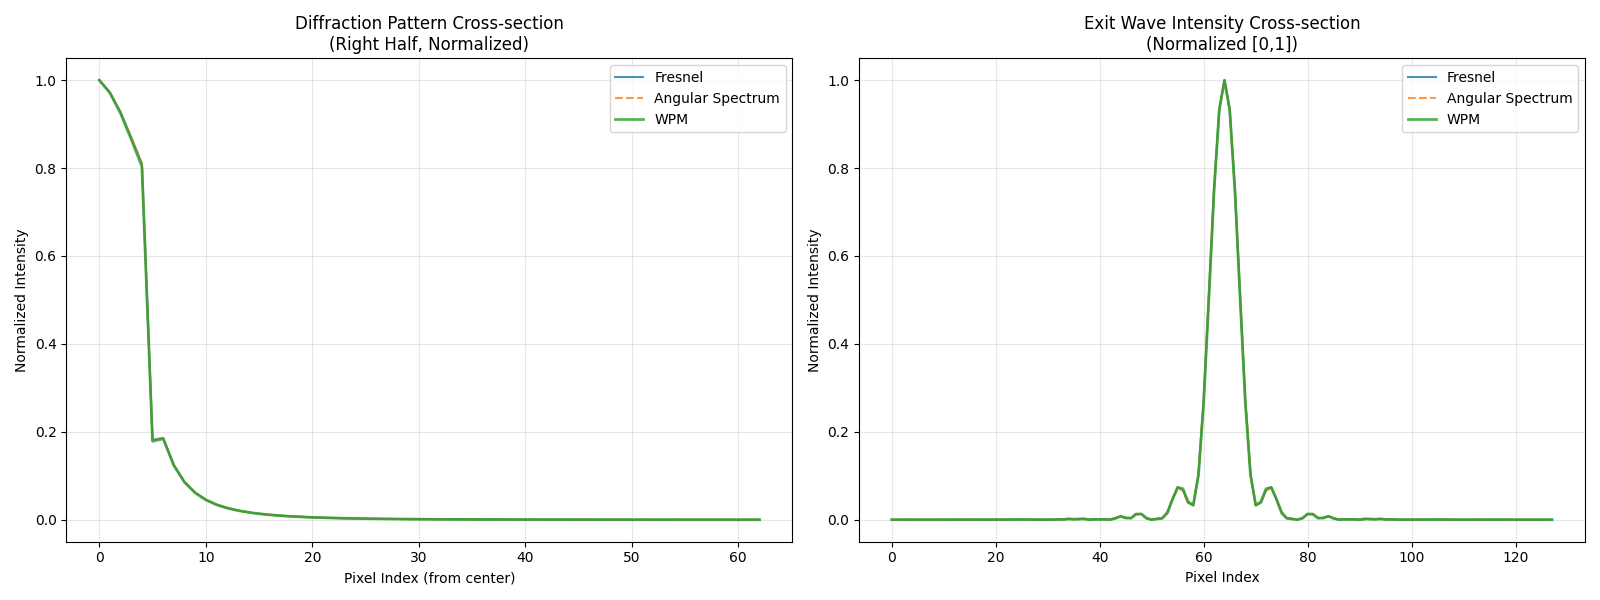

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# --- 1. Diffraction Pattern Cross-section ---
# Extract center row cross-sections
center_idx = diffraction_pattern_fresnel.shape[0] // 2
cs_f = np.asarray(diffraction_pattern_fresnel)[center_idx, :].copy()
cs_a = np.asarray(diffraction_pattern_as)[center_idx, :].copy()
cs_w = np.asarray(diffraction_pattern_wpm)[center_idx, :].copy()

# Select only the right half, skipping the central pixel (zeroth order)
mid_x = cs_f.shape[0] // 2
slice_right = slice(mid_x + 1, None)

cs_f_right = cs_f[slice_right]
cs_a_right = cs_a[slice_right]
cs_w_right = cs_w[slice_right]

# Normalize each cross-section to its own maximum for shape comparison
cs_f_n = cs_f_right / cs_f_right.max()
cs_a_n = cs_a_right / cs_a_right.max()
cs_w_n = cs_w_right / cs_w_right.max()

# Plot Diffraction Pattern
ax1.plot(cs_f_n, label='Fresnel', linestyle='-', alpha=0.8)
ax1.plot(cs_a_n, label='Angular Spectrum', linestyle='--', alpha=0.8)
ax1.plot(cs_w_n, label='WPM', linestyle='-', linewidth=2, alpha=0.8)

ax1.set_title("Diffraction Pattern Cross-section\n(Right Half, Normalized)")
ax1.set_xlabel("Pixel Index (from center)")
ax1.set_ylabel("Normalized Intensity")
ax1.legend()
ax1.grid(True, alpha=0.3)

# --- 2. Exit Wave Intensity Cross-section ---
# Calculate intensity |psi|^2
ew_f = np.abs(np.asarray(exit_wave_fresnel))**2
ew_a = np.abs(np.asarray(exit_wave_as))**2
ew_w = np.abs(np.asarray(exit_wave_wpm))**2

# Extract center row
center_idx_ew = ew_f.shape[0] // 2
cs_ew_f = ew_f[center_idx_ew, :]
cs_ew_a = ew_a[center_idx_ew, :]
cs_ew_w = ew_w[center_idx_ew, :]

# Normalize min to 0 and max to 1
cs_ew_f_n = (cs_ew_f - cs_ew_f.min()) / (cs_ew_f.max() - cs_ew_f.min())
cs_ew_a_n = (cs_ew_a - cs_ew_a.min()) / (cs_ew_a.max() - cs_ew_a.min())
cs_ew_w_n = (cs_ew_w - cs_ew_w.min()) / (cs_ew_w.max() - cs_ew_w.min())

# Plot Exit Wave
ax2.plot(cs_ew_f_n, label='Fresnel', linestyle='-', alpha=0.8)
ax2.plot(cs_ew_a_n, label='Angular Spectrum', linestyle='--', alpha=0.8)
ax2.plot(cs_ew_w_n, label='WPM', linestyle='-', linewidth=2, alpha=0.8)

ax2.set_title("Exit Wave Intensity Cross-section\n(Normalized [0,1])")
ax2.set_xlabel("Pixel Index")
ax2.set_ylabel("Normalized Intensity")
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()